In [1]:
from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from kneed import KneeLocator

from sklearn.metrics import adjusted_rand_score

In [2]:
origin=load_data('game_usage')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

게임 이용시간(time spent)과 레벨(game level)에 대한 가상 데이터

===== 데이터 크기 확인 =====
데이터셋 크기 : (100, 2)
행 개수 : 100개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   time spent  100 non-null    int64
 1   game level  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,time spent,game level
0,39,944
1,55,705
2,29,757
3,59,999
4,7,109


In [3]:
scaler=StandardScaler()
df=DataFrame(scaler.fit_transform(origin), columns=origin.columns)
df.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


In [4]:
min_samples=3

In [5]:
k=min_samples

neighbors=NearestNeighbors(n_neighbors=k)
neighbors_fit=neighbors.fit(df)
distance, indices=neighbors_fit.kneighbors(df)

s_distance=np.sort(distance, axis=0)

target=s_distance[:,k-1]
kl=KneeLocator(range(0,len(target)), target, curve='convex', direction='increasing')
eps=kl.elbow_y
print(f'eps : {eps}')

eps : 0.41251429498079606


In [6]:
delta_ratio=0.3
step_ratio=0.05

eps_min=eps*(1-delta_ratio)
eps_max=eps*(1+delta_ratio)
step=eps*step_ratio

eps_grid=np.arange(eps_min, eps_max+step, step)
eps_grid

array([0.28876001, 0.30938572, 0.33001144, 0.35063715, 0.37126287,
       0.39188858, 0.41251429, 0.43314001, 0.45376572, 0.47439144,
       0.49501715, 0.51564287, 0.53626858, 0.5568943 ])

In [7]:
labels_dict={}

for eps in eps_grid:
    estimator=DBSCAN(eps=eps, min_samples=min_samples)
    labels_dict[eps]=estimator.fit_predict(df)

labels_dict

{np.float64(0.2887600064865572): array([-1,  0,  1, -1,  2,  1, -1,  3,  4,  3, -1,  8,  5,  6, -1,  5,  7,
         5,  1,  6,  8,  9, 10,  8,  5,  1,  1,  5,  4,  6,  0,  1,  4,  5,
         7,  1,  3,  4,  2,  1,  4,  7,  1, -1,  9,  0,  1,  3, -1, 11,  4,
        10, 11, -1, -1, -1,  2,  1,  9, -1, 11,  0, -1,  6,  3,  0,  3, -1,
         3,  6,  1, -1, -1,  4, -1, 10, -1,  0,  5,  6,  2,  8,  3,  1, -1,
        -1,  1,  3,  5, 10,  0, -1,  4, -1, -1, -1,  3,  1, 10,  4]),
 np.float64(0.309385721235597): array([ 0,  1,  2, -1,  3,  2,  4,  4,  5,  4, -1,  6,  7,  4, -1,  7,  8,
         7,  2,  4,  6,  8,  9,  6,  7,  2,  2,  7,  5,  4,  1,  2,  5,  7,
         8,  2,  4,  5,  3,  2,  5,  8,  2, 11,  8,  1,  2,  4,  1, 10,  5,
         9, 10, -1, -1,  2,  3,  2,  8, -1, 10,  1, 11,  4,  4,  1,  4, -1,
         4,  4,  2, -1, -1,  5, -1,  9,  0,  1,  7,  4,  3,  6,  4,  2, -1,
        11,  2,  4,  7,  9,  1, -1,  5, -1, -1,  0,  4,  2,  9,  5]),
 np.float64(0.3300114359846368): arra

In [8]:
rows=[]

for eps in eps_grid:
    labels=labels_dict[eps]

    n_clusters=len(set(labels))-(1 if -1 in labels else 0)
    noise_ratio=np.mean(labels==-1)

    rows.append({'eps':round(eps, 4), 'n_clusters':n_clusters, 'noise_ratio':round(noise_ratio, 4)})

edf=DataFrame(rows)
edf

,eps,n_clusters,noise_ratio
0,0.2888,12,0.23
1,0.3094,12,0.14
2,0.3300,10,0.10
3,0.3506,8,0.10
4,0.3713,6,0.07
5,0.3919,6,0.03
6,0.4125,3,0.03
7,0.4331,3,0.03
8,0.4538,3,0.03
9,0.4744,3,0.01


In [9]:
ari_list=[np.nan]

for i in range(1, len(eps_grid)):
    ari=adjusted_rand_score(labels_dict[eps_grid[i-1]], labels_dict[eps_grid[i]])
    ari_list.append(round(ari, 4))

edf['ARI']=ari_list
edf

,eps,n_clusters,noise_ratio,ARI
0,0.2888,12,0.23,NaN
1,0.3094,12,0.14,0.7124
2,0.3300,10,0.10,0.7442
3,0.3506,8,0.10,0.9699
4,0.3713,6,0.07,0.6301
5,0.3919,6,0.03,0.9657
6,0.4125,3,0.03,0.2714
7,0.4331,3,0.03,1.0000
8,0.4538,3,0.03,1.0000
9,0.4744,3,0.01,0.9878


In [11]:
ari_threshold=0.9
noise_diff_threshold=0.05

edf['cluster_diff']=edf['n_clusters'].diff().abs()
edf['noise_diff']=edf['noise_ratio'].diff().abs()

edf['stable']=((edf['ARI']>=ari_threshold)&(edf['cluster_diff']==0)&(edf['noise_diff']<=noise_diff_threshold))

edf.loc[edf.index[0], 'stable']=False

edf

,eps,n_clusters,noise_ratio,ARI,cluster_diff,noise_dff,noise_diff,stable
0,0.2888,12,0.23,NaN,NaN,NaN,NaN,False
1,0.3094,12,0.14,0.7124,0.0,0.09,0.09,False
2,0.3300,10,0.10,0.7442,2.0,0.04,0.04,False
3,0.3506,8,0.10,0.9699,2.0,0.00,0.00,False
4,0.3713,6,0.07,0.6301,2.0,0.03,0.03,False
5,0.3919,6,0.03,0.9657,0.0,0.04,0.04,True
6,0.4125,3,0.03,0.2714,3.0,0.00,0.00,False
7,0.4331,3,0.03,1.0000,0.0,0.00,0.00,True
8,0.4538,3,0.03,1.0000,0.0,0.00,0.00,True
9,0.4744,3,0.01,0.9878,0.0,0.02,0.02,True


In [12]:
stable_flag=edf['stable'].astype(int).values

group_id=(stable_flag!=np.roll(stable_flag,1)).cumsum()
edf['group_id']=group_id

stable_groups=edf[edf['stable']].groupby('group_id')

group_sizes=stable_groups.size()

best_group_id=group_sizes.idxmax()

stable_eps_list=edf.loc[edf['group_id']==best_group_id, 'eps'].tolist()

stable_eps_list

[0.4331, 0.4538, 0.4744]

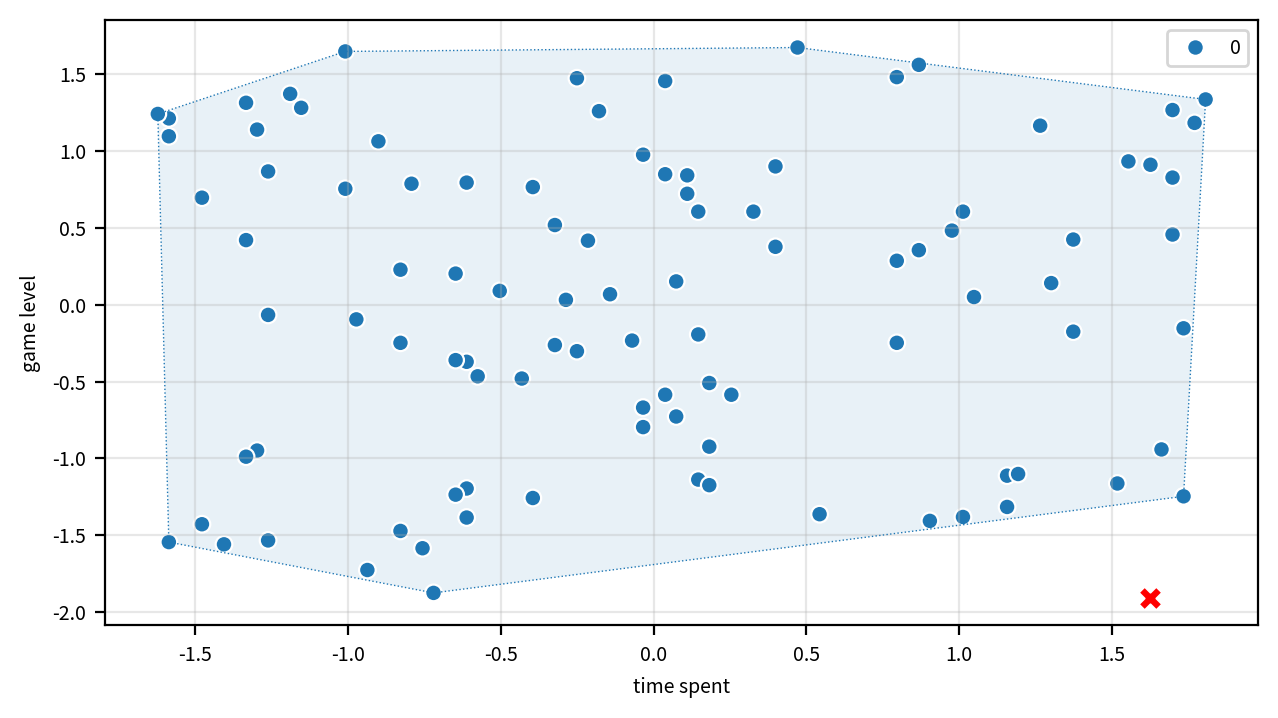

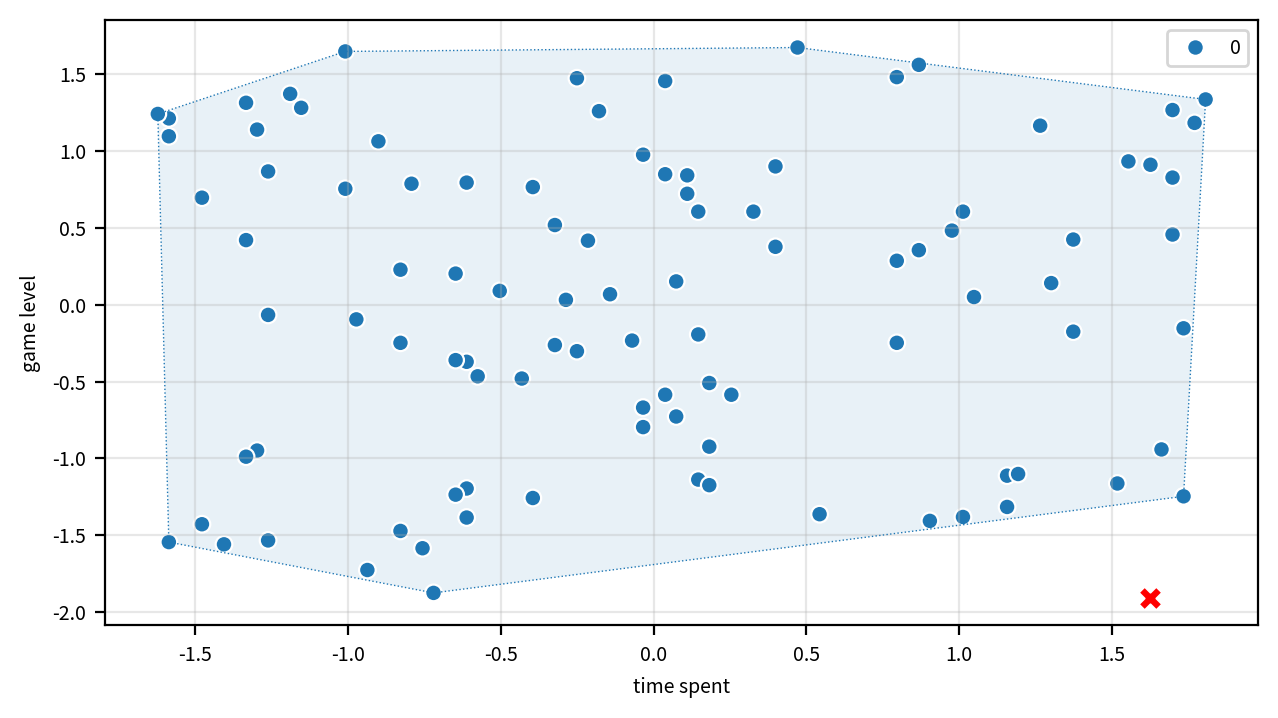

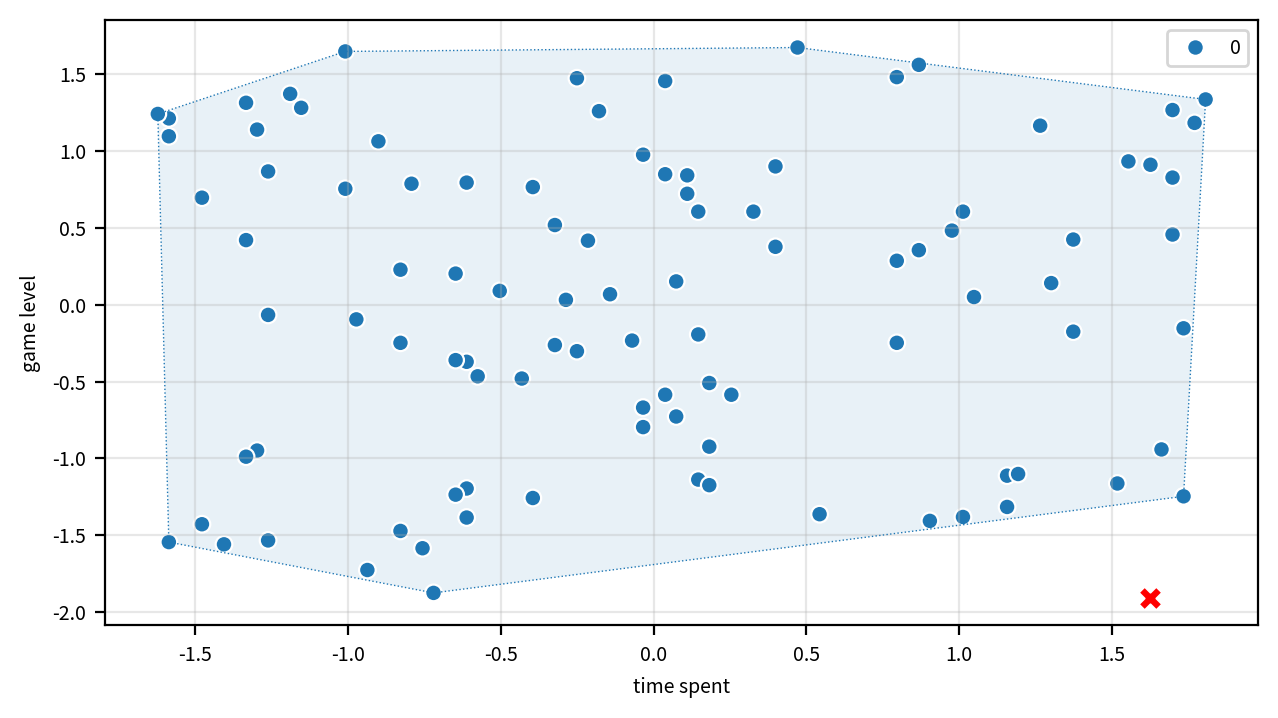

In [13]:
for e in stable_eps_list:
    estimator=DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
    estimator.fit(df)
    result_df=df.copy()
    result_df['cluster']=estimator.labels_

    result_df['vector']='border'
    result_df.loc[estimator.core_sample_indices_, 'vector']='core'
    result_df.loc[result_df['cluster']==-1, 'vector']='noise'

    vdf=result_df.copy()
    hue_field='cluster'
    x_field='time spent'
    y_field='game level'

    width_px=1280
    height_px=720
    rows=1
    cols=1
    figsize=(width_px/my_dpi, height_px/my_dpi)
    fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

    for c in vdf[hue_field].unique():
        if c==-1:
            continue
        df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]
        try:
            # 외곽선 좌표 계산
            hull=ConvexHull(df_c)
            # 마지막 좌표 이후에 첫 번째 좌표를 연결
            points=np.append(hull.vertices, hull.vertices[0])
            ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
            ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
        except:
            pass

    sb.scatterplot(data=vdf[(vdf[hue_field]!=-1)&(vdf['vector']=='core')], x=x_field, y=y_field, hue=hue_field, edgecolor='white', linewidth=0.8)
    sb.scatterplot(data=vdf[(vdf[hue_field]!=-1)&(vdf['vector']=='border')], x=x_field, y=y_field, hue=hue_field, marker='^', s=25, edgecolor='#000', linewidth=0.8)
    sb.scatterplot(data=vdf[vdf['vector']=='noise'], x=x_field, y=y_field, color="#FF0000", marker='X', s=70)

    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()